In [0]:
import os
import json
import csv
import pandas as pd
import numpy as np
import collections
from scipy.stats import zscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.8MB/s 


In [3]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
link = 'https://drive.google.com/open?id=1ZbKs_u3c4gZM-Uq0h1RCVXl6p7PnCSTf'
fluff, file_id = link.split('=')
print (file_id)
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('network_intrusion_data.csv')  
df = pd.read_csv('network_intrusion_data.csv')
#df_2 = pd.read_csv('network_intrusion_data.csv')
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

1ZbKs_u3c4gZM-Uq0h1RCVXl6p7PnCSTf


#Gems to use

In [0]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
df.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]



In [0]:
df.shape

(494020, 42)

In [0]:
df_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag-1,flag-2,flag-3,flag-4,flag-5,flag-6,flag-7,flag-8,flag-9,flag-10
0,-0.10785,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
1,-0.10785,-0.004263,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
2,-0.10785,-0.004272,-0.025041,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
3,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0
4,-0.10785,-0.004273,-0.013612,0,-0.084394,-0.004737,-0.07021,-0.018022,1,-0.007905,...,0,0,0,0,0,0,0,0,1,0


#data preprocessing

In [8]:
df[df.isnull().any(axis=1)]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome


In [9]:
df.isnull().any(axis=1).value_counts()

False    494020
dtype: int64

In [0]:
print(df.shape)
# if any' values are missing in a row, then drop that row. If inplace=True, do operation inplace and return None.
df.dropna(how='any', inplace= True)

(494020, 42)


In [0]:
df.shape

(494020, 42)

In [10]:
#removing duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(145585, 42)

#bad-good connection

In [0]:
def get_connection (row):
    if row['outcome'] == 'normal.':
        return 0
    else:
        return 1

In [0]:
df['connection_type'] = df.apply (lambda x: get_connection (x),axis=1)

In [14]:
df.connection_type.value_counts()

0    87831
1    57754
Name: connection_type, dtype: int64

one hot encoding

In [0]:
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')



In [16]:
encode_numeric_zscore(df,'duration')
encode_numeric_zscore(df,'src_bytes')
encode_numeric_zscore(df,'dst_bytes')
encode_numeric_zscore(df,'wrong_fragment')
encode_numeric_zscore(df,'urgent')
encode_numeric_zscore(df,'hot')
encode_numeric_zscore(df,'num_failed_logins')
encode_numeric_zscore(df,'num_compromised')
encode_numeric_zscore(df,'num_root')
encode_numeric_zscore(df,'num_file_creations')
encode_numeric_zscore(df,'num_shells' )
encode_numeric_zscore(df,'num_access_files')
encode_numeric_zscore(df,'count')
encode_numeric_zscore(df,'srv_count')
encode_numeric_zscore(df,'dst_host_count')
encode_numeric_zscore(df,'dst_host_srv_count')
df.shape

(145585, 120)

In [0]:
#droping the column outcome
df.drop('outcome',1,inplace=True)


In [21]:
print(x.shape,y.shape)
print(x.columns)

(145585, 118) (145585,)
Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag-REJ', 'flag-RSTO', 'flag-RSTOS0', 'flag-RSTR', 'flag-S0',
       'flag-S1', 'flag-S2', 'flag-S3', 'flag-SF', 'flag-SH'],
      dtype='object', length=118)


In [19]:
df.shape

(145585, 119)

In [0]:
y = df['connection_type']
x = df.drop('connection_type',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [0]:
print (x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(109188, 118) (109188,) (36397, 118) (36397,)


#LR

In [0]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_log = logreg.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Precision score: 0.9922510930626702
Recall score: 0.9922521086902767
F1 score: 0.99225008633257
Accuracy score: 0.9922521086902767
Log loss score: 0.26760529976259145
[[21819   119]
 [  163 14296]]
Plot of Confusion Matrix


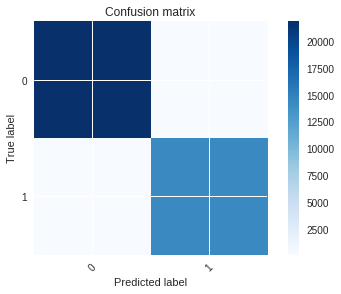

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21938
           1       0.99      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
from sklearn import metrics
y_true = y_test
pred2 = y_pred_log
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score))
score = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(score))
score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['0','1'])
plt.show()
print(classification_report(y_true,pred2))

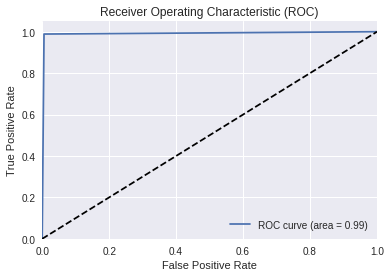

In [0]:
plot_roc(y_pred_log,y_test)

#KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=1)
print(knn1) 

knn1.fit(x_train, y_train)
y_pred_knn = knn1.predict(x_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


Precision score: 0.9990658413434637
Recall score: 0.9990658570761326
F1 score: 0.9990658460602845
Accuracy score: 0.9990658570761326
Log loss score: 0.03226450506871123
[[21922    16]
 [   18 14441]]
Plot of Confusion Matrix


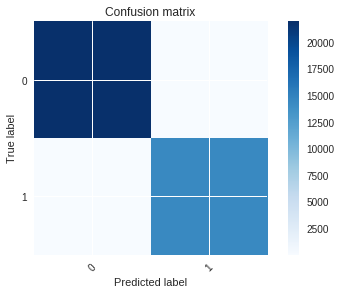

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

   micro avg       1.00      1.00      1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_knn
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score))
score = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(score))
score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['0','1'])
plt.show()
print(classification_report(y_true,pred2))

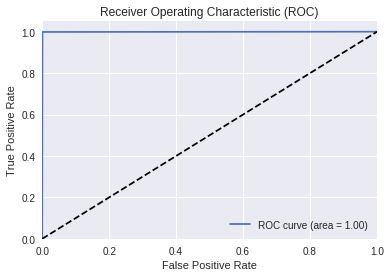

In [0]:
plot_roc(y_pred_knn,y_test)

#SVM

In [44]:
#import, instantiate, fit and predict the data
from sklearn.svm import SVC

#svm.svc
svm_model1 = SVC(C=3)

svm_model1.fit(x_train, y_train)

y_pred_svm = svm_model1.predict(x_test)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Precision score: 0.996950095417031
Recall score: 0.9969502981014918
F1 score: 0.9969500639645984
Accuracy score: 0.9969502981014918
Log loss score: 0.10533404841358358
[[21889    49]
 [   62 14397]]
Plot of Confusion Matrix


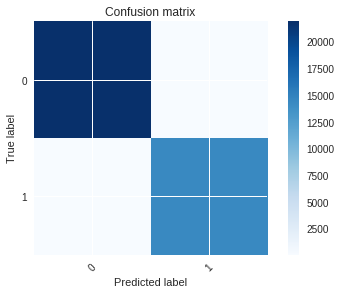

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

   micro avg       1.00      1.00      1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [45]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
from sklearn import metrics
y_true = y_test
pred2 = y_pred_svm
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(score))
score = metrics.log_loss(y_true, pred2)#this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['0','1'])
plt.show()
print(classification_report(y_true,pred2))

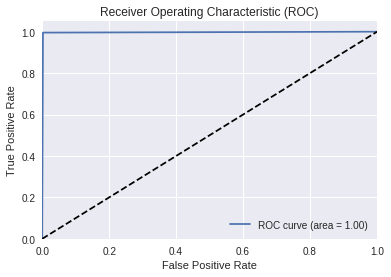

In [26]:
plot_roc(y_pred_svm,y_test)

#GNB

In [0]:
from sklearn.naive_bayes import GaussianNB
clf1 = GaussianNB()
clf1.fit(x_train, y_train)
y_pred_gnb = clf1.predict(x_test)

Precision score: 0.9261079309121599
Recall score: 0.9178503722834299
F1 score: 0.9159255149842488
Accuracy score: 0.9178503722834299
Log loss score: 2.837349885411387
[[21835   103]
 [ 2887 11572]]
Plot of Confusion Matrix


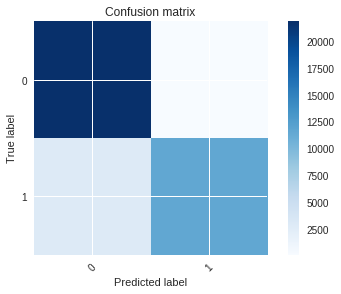

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     21938
           1       0.99      0.80      0.89     14459

   micro avg       0.92      0.92      0.92     36397
   macro avg       0.94      0.90      0.91     36397
weighted avg       0.93      0.92      0.92     36397



In [47]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_gnb
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score))
score = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(score))
score = metrics.log_loss(y_true, pred2)
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['0','1'])
plt.show()
print(classification_report(y_true,pred2))

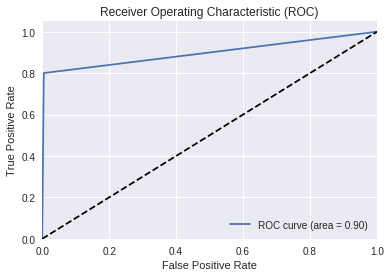

In [29]:
plot_roc(y_pred_gnb,y_test)

#Fully Connected Nueral Network

In [31]:
x2,y2= to_xy(df, 'connection_type')
print(x2.shape,y2.shape)

(145585, 118) (145585, 2)


In [0]:
# Split into train/test
x_train01, x_test01, y_train01, y_test01 = train_test_split(x2, y2, test_size=0.25, random_state=42)

In [35]:
from keras import optimizers
checkpointer = ModelCheckpoint(filepath="neural_project3_2.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x2.shape[1], activation='sigmoid'))
    model.add(Dense(10,activation='sigmoid'))
    model.add(Dense(5,activation='sigmoid'))
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
  
#print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_2.hdf5"))

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 5s - loss: 0.6615 - val_loss: 0.6404
Epoch 2/100
 - 4s - loss: 0.4206 - val_loss: 0.1544
Epoch 3/100
 - 4s - loss: 0.1137 - val_loss: 0.0984
Epoch 4/100
 - 4s - loss: 0.0921 - val_loss: 0.0890
Epoch 5/100
 - 4s - loss: 0.0847 - val_loss: 0.0822
Epoch 6/100
 - 4s - loss: 0.0776 - val_loss: 0.0746
Epoch 7/100
 - 4s - loss: 0.0701 - val_loss: 0.0676
Epoch 8/100
 - 4s - loss: 0.0643 - val_loss: 0.0629
Epoch 9/100
 - 4s - loss: 0.0600 - val_loss: 0.0591
Epoch 10/100
 - 4s - loss: 0.0565 - val_loss: 0.0557
Epoch 11/100
 - 4s - loss: 0.0530 - val_loss: 0.0519
Epoch 12/100
 - 4s - loss: 0.0489 - val_loss: 0.0470
Epoch 13/100
 - 4s - loss: 0.0437 - val_loss: 0.0406
Epoch 14/100
 - 4s - loss: 0.0379 - val_loss: 0.0345
Epoch 15/100
 - 4s - loss: 0.0328 - val_loss: 0.0297
Epoch 16/100
 - 4s - loss: 0.0291 - val_loss: 0.0263
Epoch 17/100
 - 4s - loss: 0.0264 - val_loss: 0.0239
Epoch 18/100
 - 4s - loss: 0.0244 - val_loss: 0.0221
Ep

In [36]:
checkpointer = ModelCheckpoint(filepath="neural_project3_2.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(25, input_dim=x2.shape[1], activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
  
#print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_2.hdf5"))

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 6s - loss: 0.0815 - val_loss: 0.0390
Epoch 2/100
 - 5s - loss: 0.0295 - val_loss: 0.0219
Epoch 3/100
 - 5s - loss: 0.0196 - val_loss: 0.0158
Epoch 4/100
 - 5s - loss: 0.0160 - val_loss: 0.0137
Epoch 5/100
 - 5s - loss: 0.0145 - val_loss: 0.0125
Epoch 6/100
 - 5s - loss: 0.0145 - val_loss: 0.0118
Epoch 7/100
 - 5s - loss: 0.0135 - val_loss: 0.0119
Epoch 8/100
 - 5s - loss: 0.0124 - val_loss: 0.0110
Epoch 9/100
 - 5s - loss: 0.0127 - val_loss: 0.0108
Epoch 10/100
 - 5s - loss: 0.0118 - val_loss: 0.0107
Epoch 11/100
 - 5s - loss: 0.0124 - val_loss: 0.0128
Epoch 12/100
 - 5s - loss: 0.0114 - val_loss: 0.0097
Epoch 13/100
 - 5s - loss: 0.0109 - val_loss: 0.0100
Epoch 14/100
 - 5s - loss: 0.0107 - val_loss: 0.0099
Epoch 15/100
 - 5s - loss: 0.0105 - val_loss: 0.0119
Epoch 16/100
 - 5s - loss: 0.0112 - val_loss: 0.0092
Epoch 17/100
 - 5s - loss: 0.0102 - val_loss: 0.0088
Epoch 00017: early stopping
F1 score: 0.997582332195255

In [37]:
from keras import optimizers
checkpointer = ModelCheckpoint(filepath="neural_project3_2.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(30, input_dim=x2.shape[1], activation='tanh'))
    model.add(Dense(20,activation='tanh'))
    model.add(Dense(15,activation='tanh'))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
  
#print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_2.hdf5"))

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 8s - loss: 0.0596 - val_loss: 0.0270
Epoch 2/100
 - 5s - loss: 0.0244 - val_loss: 0.0194
Epoch 3/100
 - 5s - loss: 0.0200 - val_loss: 0.0158
Epoch 4/100
 - 5s - loss: 0.0159 - val_loss: 0.0134
Epoch 5/100
 - 5s - loss: 0.0139 - val_loss: 0.0115
Epoch 6/100
 - 5s - loss: 0.0129 - val_loss: 0.0110
Epoch 7/100
 - 5s - loss: 0.0120 - val_loss: 0.0102
Epoch 8/100
 - 5s - loss: 0.0114 - val_loss: 0.0102
Epoch 9/100
 - 5s - loss: 0.0108 - val_loss: 0.0098
Epoch 10/100
 - 5s - loss: 0.0105 - val_loss: 0.0099
Epoch 11/100
 - 5s - loss: 0.0101 - val_loss: 0.0085
Epoch 12/100
 - 5s - loss: 0.0096 - val_loss: 0.0085
Epoch 13/100
 - 5s - loss: 0.0094 - val_loss: 0.0092
Epoch 14/100
 - 5s - loss: 0.0093 - val_loss: 0.0080
Epoch 15/100
 - 6s - loss: 0.0089 - val_loss: 0.0080
Epoch 16/100
 - 6s - loss: 0.0088 - val_loss: 0.0076
Epoch 00016: early stopping
F1 score: 0.9978844784196279
SGD ends
1
Train on 109188 samples, validate on 363

In [38]:
from keras import optimizers
checkpointer = ModelCheckpoint(filepath="neural_project3_2.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(35, input_dim=x2.shape[1], activation='sigmoid'))
    model.add(Dense(20,activation='tanh'))
    model.add(Dense(15,activation='relu'))
 
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
  
#print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_2.hdf5"))

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 9s - loss: 0.1078 - val_loss: 0.0562
Epoch 2/100
 - 6s - loss: 0.0455 - val_loss: 0.0350
Epoch 3/100
 - 6s - loss: 0.0311 - val_loss: 0.0261
Epoch 4/100
 - 6s - loss: 0.0250 - val_loss: 0.0211
Epoch 5/100
 - 6s - loss: 0.0218 - val_loss: 0.0191
Epoch 6/100
 - 6s - loss: 0.0200 - val_loss: 0.0177
Epoch 7/100
 - 6s - loss: 0.0186 - val_loss: 0.0167
Epoch 8/100
 - 6s - loss: 0.0178 - val_loss: 0.0158
Epoch 9/100
 - 6s - loss: 0.0171 - val_loss: 0.0154
Epoch 10/100
 - 6s - loss: 0.0165 - val_loss: 0.0152
Epoch 11/100
 - 6s - loss: 0.0161 - val_loss: 0.0147
Epoch 12/100
 - 6s - loss: 0.0158 - val_loss: 0.0141
Epoch 13/100
 - 6s - loss: 0.0156 - val_loss: 0.0140
Epoch 14/100
 - 6s - loss: 0.0153 - val_loss: 0.0151
Epoch 15/100
 - 6s - loss: 0.0149 - val_loss: 0.0135
Epoch 16/100
 - 6s - loss: 0.0147 - val_loss: 0.0132
Epoch 17/100
 - 6s - loss: 0.0146 - val_loss: 0.0130
Epoch 18/100
 - 6s - loss: 0.0143 - val_loss: 0.0132
Ep

Precision score: 0.9986262343025348
Recall score: 0.9986262604060774
F1 score: 0.9986262442063006
Accuracy score: 0.9979668654009946
Log loss score: 0.047447811909879796
[[21914    24]
 [   26 14433]]
Plot of Confusion Matrix


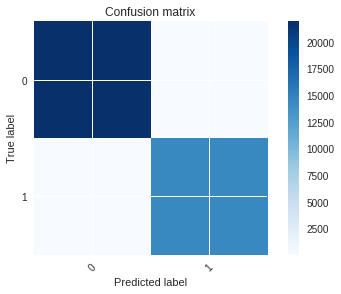

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

   micro avg       1.00      1.00      1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [42]:
#the bset classification model for 5 stars
#loading the best saved model
from keras.models import load_model
model2 = load_model(os.path.join(save_path,"neural_project3.hdf5"))
predc = model2.predict(x_test01)
predc = np.argmax(predc,axis=1)
y_true = np.argmax(y_test01,axis=1)
score = metrics.precision_score(y_true, predc, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predc, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, predc, average= "weighted")
print("F1 score: {}".format(score))
score = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(score))
score = metrics.log_loss(y_true, predc)

print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predc)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['0','1'])
plt.show()
print(classification_report(y_true,predc))

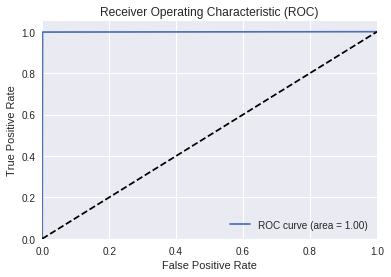

In [0]:
plot_roc(predc,y_true)

In [0]:
df2.shape

(145585, 119)

In [0]:
names = list(df2.columns) # x+y column names
names.remove('connection_type')
rank = perturbation_rank(model, x2, y2, names, False)
rank

118


,name,error,importance
0,dst_host_srv_count,0.079880,1.000000
1,hot,0.079349,0.993359
2,wrong_fragment,0.044133,0.552492
3,dst_host_count,0.043786,0.548146
4,dst_host_srv_serror_rate,0.043109,0.539679
5,count,0.040299,0.504498
6,dst_host_rerror_rate,0.037852,0.473867
7,dst_host_same_src_port_rate,0.032351,0.405002
8,flag-REJ,0.032139,0.402348
9,logged_in,0.028252,0.353683


In [0]:
from sklearn import metrics
import scipy as sp
import numpy as np
import math
from sklearn import metrics

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]
    print (len(errors))
    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

#CNN

In [48]:
print(x2.shape,y2.shape)

(145585, 118) (145585, 2)


In [49]:
# process the data to fit in a keras CNN properly， input data needs to be (N, X, Y, C) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size


x2 = x2.reshape((145585, 1, 118, 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)
# Converts a class vector (integers) to binary class matrix.  
y2 #alrady one hot encoded


# split your data to training and test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [50]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 118, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(y2.shape[1], activation="softmax"))



# show not only log loss but also accuracy for each epoch using metrics=['accuracy']

cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.25, random_state=42)

In [52]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 116, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 58, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 56, 128)        24704     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 28, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_154 (Dense)            (None, 1024)              3671040   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________

In [0]:
print("x_train",x_train2.shape)
print("y_train",y_train2.shape)
print("x_test",x_test2.shape)
print("y_test",y_test2.shape)

x_train (109188, 1, 118, 1)
y_train (109188, 2)
x_test (36397, 1, 118, 1)
y_test (36397, 2)


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
path = ""
save_path=""
import time

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="cnn_project3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn.fit(x_train2, y_train2,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test2, y_test2))
   
  pred2 = cnn.predict(x_test2)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test2,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
#cnn.save(os.path.join(save_path,"cnn_project3.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 148s - loss: 0.0232 - acc: 0.9935 - val_loss: 0.0122 - val_acc: 0.9958
Epoch 2/100
 - 147s - loss: 0.0123 - acc: 0.9966 - val_loss: 0.0066 - val_acc: 0.9979
Epoch 3/100
 - 147s - loss: 0.0102 - acc: 0.9973 - val_loss: 0.0091 - val_acc: 0.9977
Epoch 4/100
 - 147s - loss: 0.0092 - acc: 0.9975 - val_loss: 0.0059 - val_acc: 0.9980
Epoch 5/100
 - 146s - loss: 0.0080 - acc: 0.9977 - val_loss: 0.0069 - val_acc: 0.9978
Epoch 6/100
 - 146s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.0055 - val_acc: 0.9985
Epoch 7/100
 - 147s - loss: 0.0075 - acc: 0.9978 - val_loss: 0.0058 - val_acc: 0.9984
Epoch 8/100
 - 148s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.0065 - val_acc: 0.9979
Epoch 9/100
 - 147s - loss: 0.0070 - acc: 0.9981 - val_loss: 0.0052 - val_acc: 0.9983
Epoch 10/100
 - 148s - loss: 0.0064 - acc: 0.9983 - val_loss: 0.0052 - val_acc: 0.9982
Epoch 11/100
 - 148s - loss: 0.0062 - acc: 0.9983 - val_loss: 0.0060 - val_acc: 0.9983

In [53]:
# evaluate() computes the loss and accuracy
score_CNN = cnn.evaluate(x_test2, y_test2, verbose=0)
print('Test loss: {}'.format(score_CNN[0]))
print('Test accuracy: {}'.format(score_CNN[1]))

Test loss: 0.6786043905938697
Test accuracy: 0.8311948787037068


In [62]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
# define a CNN

cnn1 = Sequential()
cnn1.add(Conv2D(58, kernel_size=(1, 1), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, 118, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn1.add(MaxPooling2D(pool_size=(1,2)))

cnn1.add(Conv2D(150, kernel_size=(1, 1), strides=(1, 1),
                 activation='sigmoid'))
cnn1.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn1.add(Flatten())
cnn1.add(Dense(1024, activation="sigmoid"))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(y2.shape[1], activation="softmax"))



# show not only log loss but also accuracy for each epoch using metrics=['accuracy']

#cnn1.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.001, decay=1e-6), metrics=['accuracy'])
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 1, 118, 58)        116       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 59, 58)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 59, 150)        8850      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 29, 150)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4350)              0         
_________________________________________________________________
dense_170 (Dense)            (None, 1024)              4455424   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
__________

In [63]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers 
path = ""
save_path=""
import time

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="cnn_project3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn1.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.001, decay=1e-6), metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn1.fit(x_train2, y_train2,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test2, y_test2))
   
  pred2 = cnn1.predict(x_test2)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test2,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
#cnn.save(os.path.join(save_path,"cnn_project3.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 119s - loss: 0.7713 - acc: 0.5425 - val_loss: 0.6751 - val_acc: 0.6027
Epoch 2/100
 - 113s - loss: 0.7426 - acc: 0.5473 - val_loss: 0.6791 - val_acc: 0.6027
Epoch 3/100
 - 112s - loss: 0.7248 - acc: 0.5519 - val_loss: 0.6721 - val_acc: 0.6027
Epoch 4/100
 - 113s - loss: 0.7128 - acc: 0.5560 - val_loss: 0.6727 - val_acc: 0.6027
Epoch 5/100
 - 112s - loss: 0.7029 - acc: 0.5627 - val_loss: 0.6721 - val_acc: 0.6027
Epoch 6/100
 - 112s - loss: 0.6972 - acc: 0.5674 - val_loss: 0.6708 - val_acc: 0.6027
Epoch 7/100
 - 113s - loss: 0.6915 - acc: 0.5725 - val_loss: 0.6726 - val_acc: 0.6027
Epoch 8/100
 - 112s - loss: 0.6904 - acc: 0.5742 - val_loss: 0.6726 - val_acc: 0.6027
Epoch 9/100
 - 112s - loss: 0.6862 - acc: 0.5803 - val_loss: 0.6708 - val_acc: 0.6027
Epoch 10/100
 - 113s - loss: 0.6843 - acc: 0.5825 - val_loss: 0.6765 - val_acc: 0.6027
Epoch 11/100
 - 114s - loss: 0.6820 - acc: 0.5877 - val_loss: 0.6706 - val_acc: 0.6027

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
# evaluate() computes the loss and accuracy
score_CNN = cnn1.evaluate(x_test2, y_test2, verbose=0)
print('Test loss: {}'.format(score_CNN[0]))
print('Test accuracy: {}'.format(score_CNN[1]))

Test loss: 0.6706073542140646
Test accuracy: 0.6027419842376576


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
# define a CNN

cnn2 = Sequential()
cnn2.add(Conv2D(50, kernel_size=(1, 5), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, 118, 1)))


cnn2.add(MaxPooling2D(pool_size=(1,2)))


    
    
cnn2.add(Flatten())
cnn2.add(Dense(512, activation="tanh"))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(y2.shape[1], activation="softmax"))



# show not only log loss but also accuracy for each epoch using metrics=['accuracy']

#cnn2.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


In [66]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
path = ""
save_path=""
import time

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="cnn_project3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn2.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn2.fit(x_train2, y_train2,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test2, y_test2))
   
  pred2 = cnn2.predict(x_test2)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test2,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
#cnn.save(os.path.join(save_path,"cnn_project3.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 53s - loss: 0.0283 - acc: 0.9909 - val_loss: 0.0125 - val_acc: 0.9964
Epoch 2/100
 - 48s - loss: 0.0157 - acc: 0.9953 - val_loss: 0.0104 - val_acc: 0.9971
Epoch 3/100
 - 51s - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0104 - val_acc: 0.9968
Epoch 4/100
 - 50s - loss: 0.0112 - acc: 0.9967 - val_loss: 0.0072 - val_acc: 0.9977
Epoch 5/100
 - 49s - loss: 0.0104 - acc: 0.9968 - val_loss: 0.0091 - val_acc: 0.9969
Epoch 6/100
 - 50s - loss: 0.0092 - acc: 0.9973 - val_loss: 0.0058 - val_acc: 0.9982
Epoch 7/100
 - 50s - loss: 0.0089 - acc: 0.9973 - val_loss: 0.0069 - val_acc: 0.9978
Epoch 8/100
 - 50s - loss: 0.0084 - acc: 0.9974 - val_loss: 0.0054 - val_acc: 0.9985
Epoch 9/100
 - 50s - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0058 - val_acc: 0.9981
Epoch 10/100
 - 50s - loss: 0.0080 - acc: 0.9977 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 11/100
 - 50s - loss: 0.0078 - acc: 0.9976 - val_loss: 0.0081 - val_acc: 0.9974
Epoch 0001

In [68]:
# evaluate() computes the loss and accuracy
score_CNN = cnn2.evaluate(x_test2, y_test2, verbose=0)
print('Test loss: {}'.format(score_CNN[0]))
print('Test accuracy: {}'.format(score_CNN[1]))

Test loss: 0.008141129566665002
Test accuracy: 0.9973624199796687


Precision score: 0.9985165556901177
Recall score: 0.9985163612385636
F1 score: 0.9985162034101522
Accuracy score: 0.9973624199796687
Log loss score: 0.09110041223510992
[[21920    18]
 [   36 14423]]
Plot of Confusion Matrix


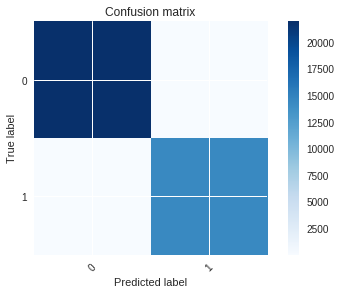

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

   micro avg       1.00      1.00      1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [69]:
from sklearn import metrics
from keras.models import load_model
model3 = load_model(os.path.join(save_path,"cnn_project3.hdf5"))
predcn = model3.predict(x_test2)
predcn = np.argmax(predcn,axis=1)
y_true = np.argmax(y_test2,axis=1)
score = metrics.precision_score(y_true, predcn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predcn, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, predcn, average= "weighted")
print("F1 score: {}".format(score))
score = metrics.accuracy_score(y_true, pred2)
print("Accuracy score: {}".format(score))
score = metrics.log_loss(y_true, pred2)
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predcn)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['0','1'])
plt.show()
print(classification_report(y_true,predcn))

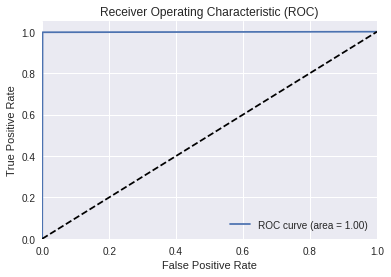

In [0]:
plot_roc(predcn,y_true)